In [1]:
from mongo_connection import Mongo_connection
import numpy as np
import pandas as pd
import pair_transition_analysis
import granger_causation_test
from matplotlib import pyplot as plt

In [2]:
mongo = Mongo_connection()
mongo.connect()

[INFO] Created a mongodb instance.
[INFO] Currently connected to eye_tracking_db/fixation_sequences.
[INFO] Found 66 documents.


In [ ]:
pID = "002"
trial = 2
document = mongo.find_one({"pID": pID, "trial": trial})

In [3]:
d_data = document["data"]
df_data = pd.DataFrame(d_data)

sr = 10
signal = granger_causation_test.create_signal_from_transitions(df_data, sr)

df_granger = granger_causation_test.granger_causality_test(signal)

print(df_granger[df_granger["pval"] < 0.05])

        roi1     roi2 lag   pval
0     runway  rpmleft   0  0.036
2     runway  rpmleft   2  0.009
3     runway  rpmleft   3  0.020
4     runway  rpmleft   4  0.005
5     runway  rpmleft   5  0.009
..       ...      ...  ..    ...
345  unknown     nrst   5  0.000
346  unknown     nrst   6  0.000
347  unknown     nrst   7  0.000
348  unknown     nrst   8  0.000
349  unknown     nrst   9  0.000

[123 rows x 4 columns]


In [20]:
metadata = {
    "pID": pID,
    "trial": trial,
    "sr": sr
}

In [28]:
from statsmodels.tsa.stattools import grangercausalitytests, adfuller, kpss

def run_adf_kpss_test(signals_from_transitions):
    lroi = []
    lstat = []
    lpval = []
    lnlag = []
    lcritval = []
    ltesttype = []

    for k, v in signals_from_transitions.items():
        signal = v
        adf_result = adfuller(signal)
        lroi.append(k)
        ltesttype.append("adf")
        lstat.append(adf_result[0])
        lpval.append(round(adf_result[1],3))
        lnlag.append(adf_result[2])
        lcritval.append(adf_result[4])

        kpss_result = kpss(signal, nlags="auto")
        lroi.append(k)
        ltesttype.append("kpss")
        lstat.append(kpss_result[0])
        lpval.append(round(kpss_result[1],3))
        lnlag.append(kpss_result[2])
        lcritval.append(kpss_result[3])
    
    df_test = pd.DataFrame({"roi": lroi,
                            "test_type": ltesttype,
                            "stat_val": lstat,
                            "pval": lpval,
                            "nlag": lnlag,
                            "crit_val": lcritval})

    return df_test

In [54]:
df_data = pd.DataFrame(signal)
variables = df_data.columns

In [55]:
# split data into train and test. We will need this later for VAR analysis
msk = np.random.rand(len(df_data)) < 0.8
train = df_data[msk]
test = df_data[~msk]

In [50]:
from statsmodels.tsa.api import VAR
from statsmodels.tools.eval_measures import rmse, aic

In [51]:
model = VAR(df_data) #recall that rawData is w/o difference operation
for i in [1,2,3,4,5,6,7,8,9,10,11,12]:
    result = model.fit(i)
    try:
        print('Lag Order =', i)
        print('AIC : ', result.aic)
        print('BIC : ', result.bic)
        print('FPE : ', result.fpe)
        print('HQIC: ', result.hqic, '\n')
    except:
        continue

Lag Order = 1
AIC :  -30.552298327008575
BIC :  -30.35689516057881
FPE :  5.3864882644864396e-14
HQIC:  -30.479570932446023 

Lag Order = 2
AIC :  -30.72201282579884
BIC :  -30.355436969840778
FPE :  4.545705312452558e-14
HQIC:  -30.585571939593585 

Lag Order = 3
AIC :  -30.847746779235155
BIC :  -30.30981597803985
FPE :  4.0086659604443134e-14
HQIC:  -30.64752038011131 

Lag Order = 4
AIC :  -30.973197572401062
BIC :  -30.26372925313849
FPE :  3.5361049616912106e-14
HQIC:  -30.709113510242908 

Lag Order = 5
AIC :  -30.968344554938664
BIC :  -30.087155826897888
FPE :  3.553412038565787e-14
HQIC:  -30.64033055047671 

Lag Order = 6
AIC :  -31.004619118470835
BIC :  -29.951526772297857
FPE :  3.426972654677634e-14
HQIC:  -30.61260276296687 

Lag Order = 7
AIC :  -31.062261474951196
BIC :  -29.837081981884463
FPE :  3.2352150005266196e-14
HQIC:  -30.606170229882398 

Lag Order = 8
AIC :  -31.072180670042638
BIC :  -29.674730181146213
FPE :  3.203539997939335e-14
HQIC:  -30.5519418667846

In [56]:
# Lag Order = 10
# FPE :  3.065944644454407e-14

model = VAR(train)
model_fitted = model.fit(10)

c:\users\work\anaconda3\envs\kia\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


In [58]:
from statsmodels.stats.stattools import durbin_watson
out = durbin_watson(model_fitted.resid)

for col, val in zip(df_data.columns, out):
    print(col, ':', round(val, 2))

unknown : 1.96
runway : 2.0
hsi : 1.98
nrst : 2.02
asi : 2.0
rpmleft : 2.0
alt : 2.01


In [59]:
import statsmodels.tsa.stattools as ts 
result=ts.coint(df_data['runway'], df_data['asi'])
print(result)

(-5.949862100334587, 2.0810372613706883e-06, array([-3.90362183, -3.34013168, -3.04722682]))


In [60]:
lag_order = model_fitted.k_ar

In [62]:
test = 'ssr_chi2test'
maxlag = lag_order
def grangers_causation_matrix(data, variables, test='ssr_chi2test', verbose=False):    
    """Check Granger Causality of all possible combinations of the Time series.
    The rows are the response variable, columns are predictors. The values in the table 
    are the P-Values. P-Values lesser than the significance level (0.05), implies 
    the Null Hypothesis that the coefficients of the corresponding past values is 
    zero, that is, the X does not cause Y can be rejected.

    data      : pandas dataframe containing the time series variables
    variables : list containing names of the time series variables.
    """
    df = pd.DataFrame(np.zeros((len(variables), len(variables))), columns=variables, index=variables)
    for c in df.columns:
        for r in df.index:
            test_result = grangercausalitytests(data[[r, c]], maxlag=maxlag, verbose=False)
            p_values = [round(test_result[i+1][0][test][1],4) for i in range(maxlag)]
            if verbose: print(f'Y = {r}, X = {c}, P Values = {p_values}')
            min_p_value = np.min(p_values)
            df.loc[r, c] = min_p_value
    df.columns = [var + '_x' for var in variables]
    df.index = [var + '_y' for var in variables]
    return df


In [63]:
grangers_causation_matrix(df_data, variables)

c:\users\work\anaconda3\envs\kia\lib\site-packages\statsmodels\base\model.py:1834: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 4, but rank is 2
  'rank is %d' % (J, J_), ValueWarning)
c:\users\work\anaconda3\envs\kia\lib\site-packages\statsmodels\base\model.py:1834: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 5, but rank is 2
  'rank is %d' % (J, J_), ValueWarning)


,unknown_x,runway_x,hsi_x,nrst_x,asi_x,rpmleft_x,alt_x
unknown_y,1.0000,0.2595,0.9469,0.0000,0.0434,0.8468,0.2864
runway_y,0.0620,1.0000,0.2414,0.0048,0.0000,0.0021,0.0000
hsi_y,0.9288,0.0593,1.0000,0.8682,0.7186,0.8413,0.1666
nrst_y,0.0000,0.0463,0.9072,1.0000,0.5425,0.1033,0.0022
asi_y,0.1348,0.0000,0.1727,0.3972,1.0000,0.0018,0.0002
rpmleft_y,0.8180,0.0022,0.8587,0.2099,0.0000,1.0000,0.3558
alt_y,0.6967,0.0000,0.0337,0.4683,0.0000,0.3812,1.0000


In [30]:
def draw_signals(signal, rois, metadata):
    """
    signal: return from granger_causation_test.create_signal_from_transitions
    rois: 2 rois that you want to draw together."""
    fig, ax = plt.subplots(figsize=(15,8))
    ax.plot(signal[rois[0]], label=rois[0])
    ax.plot(signal[rois[1]], label=rois[1])
    ax.set_xlabel(f"time (sampling rate = {metadata['sr']} Hz)")
    ax.legend()
    plt.title("gaze signal")

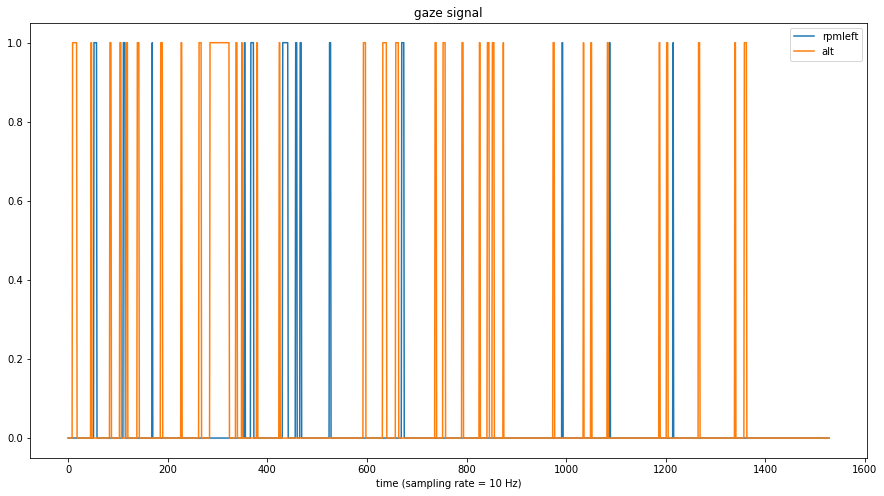

In [31]:
draw_signals(signal, ["rpmleft", "alt"], metadata)